In [1]:
using LinearAlgebra, PyPlot, BenchmarkTools

In [234]:
A = [3.0 2.0
     2.0 6.0]
b = [2.0, -8.0]

isposdef(A)

true

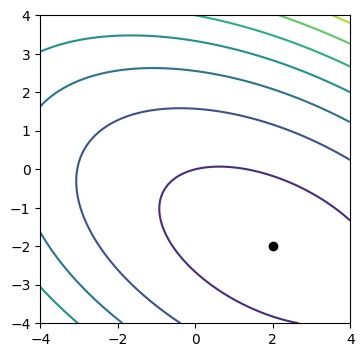

PyObject <matplotlib.collections.PathCollection object at 0x1507e6050>

In [237]:
x = -4.0:0.1:+4.0
y = -4.0:0.1:+4.0
xs = zeros(length(x), length(y))
ys = zeros(length(x), length(y))
zs = zeros(length(x), length(y))

for i=1:length(x)
    for j=1:length(y)
        v = [x[i], y[j]]
        xs[i,j] = v[1]
        ys[i,j] = v[2]
        zs[i,j] = 0.5 * v' * A * v - v' * b
    end
end

figure(figsize=(4,4))
contour(xs, ys, zs)
scatter(2.0, -2.0, c="k")

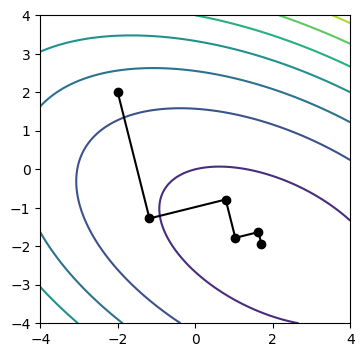

([-1.180722891566265, -1.2771084337349397], [1.7067954325649235, -1.9333625983102096])

In [155]:
function steepest_descent_step(A, b, x_k)
    r_k = b - A * x_k
    if (r_k' * r_k) < eps(Float64)
        return x_k
    end
    α   = (r_k' * r_k) / (r_k' * A * r_k)
    x_k = x_k + α * r_k
end

x_0 = [-2.0, 2.0]
x_1 = steepest_descent_step(A, b, x_0)
x_2 = steepest_descent_step(A, b, x_1)
x_3 = steepest_descent_step(A, b, x_2)
x_4 = steepest_descent_step(A, b, x_3)
x_5 = steepest_descent_step(A, b, x_4)

figure(figsize=(4,4))
contour(xs, ys, zs)

ps = hcat(x_0, x_1, x_2, x_3, x_4, x_5)
plot(ps[1,:], ps[2,:], "k-o")
x_1, x_5

In [154]:
x_0

2-element Vector{Float64}:
  1.1055728090000843
 -1.5527864045000421

In [5]:
function steepest_descent!(A, b, x)
    r = b - A * x
    δ = r' * r
    history = zeros(100) * NaN
    for it=1:100 #if (δ < 1e-10) @show it; break end
        q = A * r
        α = δ / (r' * q)
        x .+= α .* r
        
        r = b - A * x
        #r .-= α .* q # fast residual
        history[it] = norm(r)
        
        δ = r' * r
    end
    return history
end

steepest_descent! (generic function with 1 method)

In [206]:
function conjugate_gradient!(A, b, x)
    r = b - A * x
    d = r
    δ_i = δ_j = r' * r
    history = zeros(100) * NaN
    for it=1:100 #if (δ_j < 1e-10) break end
        q = A * d
        α = δ_j / (d' * q)
        x += α * d
        
        #r = b - A * x
        r -= α * q # fast residual
        history[it] = norm(b - A * x)
        
        δ_i,δ_j = δ_j, (r' * r)
        β = δ_j / δ_i
        d = r + β * d
    end
    return history
end

conjugate_gradient! (generic function with 2 methods)

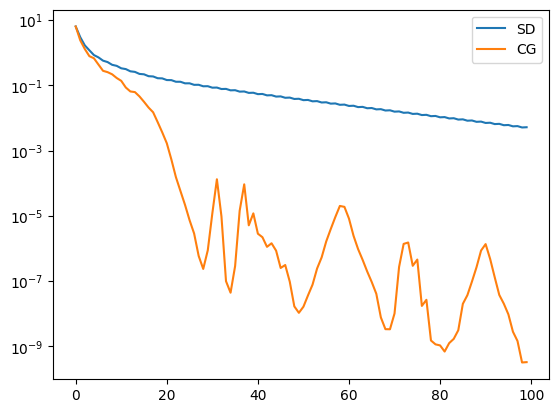

PyObject <matplotlib.legend.Legend object at 0x150d29890>

In [207]:
semilogy(steepest_descent!(A, b, zeros(length(b))))
semilogy(conjugate_gradient!(A, b, zeros(length(b))))
legend(("SD", "CG"))

In [229]:
function fdmproblem(n)
    m = n
    A = zeros(n*m, n*m)
    dof = reshape(1:n*m, n, m)
    for i=2:n, j=1:m
        A[dof[i,j], dof[i-1,j]] -= 1.0
        A[dof[i,j], dof[i,j]] += 1.0
    end
    for i=1:n, j=2:m
        A[dof[i,j], dof[i,j-1]] -= 1.0
        A[dof[i,j], dof[i,j]] += 1.0
    end
    for i=1:n-1, j=1:m
        A[dof[i,j], dof[i+1,j]] -= 1.0
        A[dof[i,j], dof[i,j]] += 1.0
    end
    for i=1:n, j=1:m-1
        A[dof[i,j], dof[i,j+1]] -= 1.0
        A[dof[i,j], dof[i,j]] += 1.0
    end
    for i=(1,n), j=1:m
        A[dof[i,j], :] .= 0.0
        A[dof[i,j], dof[i,j]] = 1.0
    end
    for i=1:n, j=(1,m)
        A[dof[i,j], :] .= 0.0
        A[:, dof[i,j]] .= 0.0
        A[dof[i,j], dof[i,j]] = 1.0
    end    
    x = zeros(n*m)
    for i=1:n, j=1:m
        x[dof[i,j]] += sin(1.0π * (i-1)/(n-1))
        x[dof[i,j]] += sin(1.0π * (j-1)/(m-1))
    end
    b = A * x
    free = vec([dof[i, j] for i=2:n-1, j=2:m-1])
    return A[free, free], b[free]
end
A, b = fdmproblem(15)
size(A, 1), isposdef(A), cond(A)

(169, true, 78.76998224097103)

In [225]:
using LinearAlgebra
using PyPlot
using BenchmarkTools

using LinearAlgebra

stiffness_element(lx, ly) =
[lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx
 lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx]

mass_element(lx, ly) = (lx * ly) / 6.0 *
[ 2. 0 -1  0
  0  2  0 -1
 -1  0  2  0
  0 -1  0  2]

function assemble!(S, R, T, el2ed, el2edd, dof, lx, ly, nelem, ndof; εr=1, μr=1, ε0=8.854e-12, μ0=4e-7π)
  # ASSUMPTION: Waveguide is homogenous
  # Assemble stiffness and mass matrices
  ε = εr*ε0
  for ielem = 1:nelem # Assemble by elements
    Se = stiffness_element(lx, ly)
    Te = mass_element(lx, ly)
    
    for jedge = 1:4
      dj = el2edd[ielem, jedge]
      jj = dof[el2ed[ielem, jedge]]
      if jj == 0
        continue
      end
      
      for kedge = 1:4
        dk = el2edd[ielem, kedge]
        kk = dof[el2ed[ielem, kedge]]
        if kk == 0
          continue
        end
  
        S[jj, kk] = S[jj, kk] + dj * dk * (1/μr) * Se[jedge, kedge]
        T[jj, kk] = T[jj, kk] + dj * dk * (μ0*ε) * Te[jedge, kedge]
      end
    end
  end
  return nothing
end

function lhs(S, T, R, Δt)
  A = (+0.25Δt^2 * S +  T + 0.5Δt * R)
end

function rhs(S, T, R, Δt, ep, epp)
  b = (-0.25Δt^2 * S -  T + 0.5Δt * R) * epp +
      (-0.50Δt^2 * S + 2T) * ep
end

function quadmesh(a, b, Nx, Ny)
    NUM_EDGES = 2(Nx*Ny) + Nx + Ny
    NUM_ELEMS = Nx * Ny
    
    el2edd = repeat([+1 +1 -1 -1], NUM_ELEMS)
    el2ed = zeros(Int64, NUM_ELEMS, 4)
    for jj = 1:Ny
        for ii = 1:Nx
            kk = (jj-1)Nx + ii
            el2ed[kk, :]  .= [ii, ii+Nx+1, ii+Nx+1+Nx, ii+Nx]
            el2ed[kk, :] .+= (jj-1) * (Nx + Nx + 1)
        end
    end

    return el2ed, el2edd, NUM_EDGES
end

function femproblem(n)
    m = n
    @assert n * m < 40*40 "Are you sure? Try smaller problem first!"
    
    # parameters
    Δt = 0.01e-9
    Lx = 2.00
    Ly = 2.00
    lx = Lx / n
    ly = Ly / m
    el2ed, el2edd, nedge = quadmesh(Lx, Ly, n, m);
    
    # degrees of freedom
    DOF_NONE = 0
    DOF_PEC  = 1

    h = [  1+(2n+1)i: n+0+(2n+1)i for i=0:m]
    v = [n+1+(2n+1)i:2n+1+(2n+1)i for i=0:m-1]

    Γ = zeros(Int64, nedge)
    Γ[first(h)] .= DOF_PEC
    Γ[last(h)]  .= DOF_PEC
    for i=1:m
         Γ[first(v[i])] = DOF_PEC
         Γ[last(v[i])] = DOF_PEC
    end

    dof = collect(1:nedge)
    free = Γ .!= DOF_PEC

    # assemble finite element matrices
    S = zeros(nedge, nedge)
    T = zeros(nedge, nedge)
    R = zeros(nedge, nedge)
    assemble!(S, T, R, el2ed, el2edd, dof, lx, ly, n*m, nedge)
    
    # construct the problem left hand side
    A = lhs(S[free, free], T[free, free], R[free, free], Δt);
    
    # calculate eigensolution and use it as a starting point
    k², v = eigen(Array(S[free, free]), Array(T[free, free]))
    
    e = zeros(nedge)
    ep = copy(e)
    epp = copy(e)
    ep[free] .= epp[free] .= v[:, 1+(n-1)*(m-1)]
    
    # construct the problem right hand side
    b = rhs(S[free, free], T[free, free], R[free, free], Δt, ep[free], epp[free])
    
    return 1e23A, 1e23b
end
A, b = femproblem(8)
size(A, 1), isposdef(A), cond(A)

(112, true, 1.5425485240924665e8)

In [226]:
function conjugate_gradient!(M, A, b, x)
    r = b - A * x
    d = M \ r
    δ_i = δ_j = r' * d
    history = zeros(100) * NaN
    for it=1:100 #if (δ_j < 1e-10) break end
        q = A * d
        α = δ_j / (d' * q)
        x += α * d
        
        #r = b - A * x
        r -= α * q # fast residual
        history[it] = norm(b - A * x)
        
        s = M \ r
        δ_i,δ_j = δ_j, (r' * s)
        β = δ_j / δ_i
        d = s + β * d
    end
    
    return history
end

conjugate_gradient! (generic function with 2 methods)

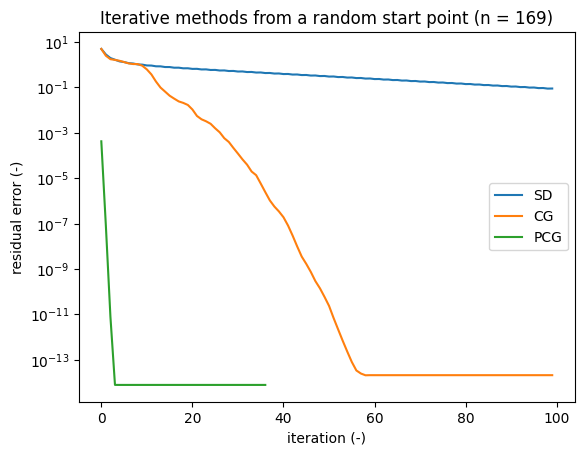

PyObject Text(24.000000000000007, 0.5, 'residual error (-)')

In [232]:
using IncompleteLU, SparseArrays
#M = I(length(b))
#M = Diagonal(A)
M = ilu(sparse(A), τ=0.0001)
x = rand(length(b))

semilogy(steepest_descent!(A, b, copy(x)))
semilogy(conjugate_gradient!(A, sparse(b), copy(x)))
semilogy(conjugate_gradient!(M, sparse(A), b, copy(x)))
legend(("SD", "CG", "PCG"));
xlabel("iteration (-)")
title("Iterative methods from a random start point (n = $(length(b)))")
ylabel("residual error (-)")